In [1]:
from fastai.vision.all import *
from fastai.learner import *
from fastai.data.all import *
from fastai.callback.tracker import SaveModelCallback
import pandas as pd
import matplotlib.pyplot as plt
from pathlib2 import Path
import numpy as np
import random
from torch.nn import MSELoss
import logging
from six import iteritems
from web.datasets.similarity import fetch_MEN, fetch_WS353, fetch_SimLex999
from web.embeddings import fetch_GloVe
from web.evaluate import evaluate_similarity
from web.embedding import Embedding, Vocabulary
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.datasets.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


You can download the ebooks [here](https://www.openslr.org/resources/12/original-books.tar.gz).

We will need the pretrained embeddings from https://github.com/iamyuanchung/speech2vec-pretrained-vectors. We will use them to compare our results and also to figure out what vocab the authors of the speech2vec paper used for training. Let us start with the latter.

In [2]:
df_train = pd.read_csv('data/wikitext-103/train.csv', header=None)

In [3]:
df_train.shape

(29539, 1)

In [4]:
from joblib import Parallel, delayed
from functools import partial
from spacy.util import minibatch
import spacy
from spacy.attrs import ORTH, LEMMA

nlp = spacy.load("en_core_web_sm")

nlp.tokenizer.add_special_case('<unk>', [{ORTH: "<unk>"}])
nlp.tokenizer.add_special_case('<eos>', [{ORTH: "<eos>"}])

batch_size= 200

executor = Parallel(n_jobs=8, backend="multiprocessing", prefer="threads")

def transform_texts(nlp, text):
    docs = nlp.tokenizer.pipe(text)
    word_pairs = []
    
    for doc in docs:
        words = [token.text.lower() for token in doc if token.is_alpha]
        
        for i, word in enumerate(words):
            for offset in [-2, -1, 1, 2]:
                if i + offset < 0 or i + offset >= len(words): continue
                target_word = words[i+offset]
                word_pairs.append([word, target_word])
                 
    return word_pairs

In [6]:
all_texts = df_train[0].tolist()
# texts = texts[:10_000]

In [7]:
partitions = minibatch(all_texts, size=batch_size)

In [8]:
%%time

do = delayed(partial(transform_texts, nlp))
tasks = (do(batch) for batch in partitions)
word_pairs_hierarchical = executor(tasks)

CPU times: user 4min 54s, sys: 44.1 s, total: 5min 38s
Wall time: 6min


In [9]:
word_pairs = []

for pairs in word_pairs_hierarchical: word_pairs += pairs

In [10]:
len(word_pairs)

327311802

In [11]:
ws = []
for w1, w2 in word_pairs:
    ws.append(w1)
    ws.append(w2)

In [12]:
len(ws)

654623604

In [13]:
c = Counter(ws)

In [14]:
vocab = [v for v, count in c.most_common(37622)]

In [15]:
vocab_set = set(vocab)

In [16]:
word_pairs_old = word_pairs

word_pairs = [[w1, w2] for w1, w2 in word_pairs_old if w1 in vocab_set and w2 in vocab_set]

In [17]:
vocab = list(vocab)

In [18]:
# pd.to_pickle(vocab, 'data/vocab.pkl')
# pd.to_pickle(word_pairs, 'data/word_pairs.pkl')

In [2]:
%%time

vocab = pd.read_pickle('data/vocab.pkl')
word_pairs = pd.read_pickle('data/word_pairs.pkl')

CPU times: user 2min 58s, sys: 23.2 s, total: 3min 21s
Wall time: 3min 25s


In [3]:
word_pairs[:10]

[['is', 'a'],
 ['is', 'fungal'],
 ['a', 'is'],
 ['a', 'fungal'],
 ['a', 'genus'],
 ['fungal', 'is'],
 ['fungal', 'a'],
 ['fungal', 'genus'],
 ['fungal', 'in'],
 ['genus', 'a']]

In [4]:
len(word_pairs)

308171282

In [5]:
word2index = {w: i for i, w in enumerate(vocab)}

In [6]:
class Dataset():
    def __init__(self, pairs, length=10_000_000):
        self.pairs = pairs
        self.len = length
    def __len__(self):
        return self.len
    def __getitem__(self, idx):
        source_word, target_word = self.pairs[np.random.randint(len(self.pairs))]
        return word2index[source_word], word2index[target_word]

In [7]:
# 14 mln -> 180 mln

In [8]:
len(word_pairs)

308171282

In [9]:
train_ds = Dataset(word_pairs)
valid_ds = Dataset(word_pairs, 200_000)

In [10]:
len(train_ds), len(valid_ds)

(10000000, 200000)

In [11]:
BS = 2048
NUM_WORKERS = 1

train_dl = DataLoader(train_ds, BS, NUM_WORKERS, shuffle=True)
valid_dl = DataLoader(valid_ds, BS, NUM_WORKERS)

dls = DataLoaders(train_dl, valid_dl)

In [12]:
class Model(Module):
    def __init__(self, hidden_size=50):
        self.embeddings =nn.Embedding(len(vocab), hidden_size)
        self.linear = nn.Linear(hidden_size, len(vocab))
            
    def forward(self, x):
        x = self.embeddings(x)
        return self.linear(x)

In [13]:
learn = Learner(
    dls.cuda(),
    Model().cuda(),
    loss_func=CrossEntropyLossFlat(),
    opt_func=Adam,
    metrics=[accuracy]
)

In [14]:
NUM_EPOCHS = 100
learn.fit(NUM_EPOCHS, lr=1e-3, cbs=SaveModelCallback(fname='text_embeddings', every_epoch=True))

epoch,train_loss,valid_loss,accuracy,time
0,7.269180,7.257636,0.087260,02:11
1,7.161187,7.169810,0.089320,02:14
2,7.123416,7.123930,0.090830,02:13
3,7.089708,7.097736,0.093410,02:13
4,7.074082,7.070145,0.093105,02:14
5,7.049150,7.052279,0.093615,02:12
6,7.039858,7.033509,0.092855,02:13
7,7.008097,7.006872,0.093465,02:12
8,7.013725,7.013301,0.094955,02:13
9,7.015170,6.992450,0.093925,02:13


In [15]:
NUM_EPOCHS = 40
learn.fit(NUM_EPOCHS, lr=1e-4, cbs=SaveModelCallback(fname='text_embeddings_2', every_epoch=True))

epoch,train_loss,valid_loss,accuracy,time
0,6.886898,6.868276,0.098055,02:12
1,6.873828,6.878359,0.097220,02:13
2,6.878247,6.873122,0.096530,02:13
3,6.873173,6.886355,0.096985,02:13
4,6.874283,6.881660,0.096835,02:13
5,6.860350,6.865623,0.097675,02:12
6,6.870786,6.876698,0.097630,02:12
7,6.871454,6.866683,0.097235,02:12
8,6.867239,6.858534,0.097075,02:12
9,6.871249,6.881573,0.096275,02:14


## Evalute embeddings

In [16]:
from utils import Embeddings

In [17]:
embeddings = learn.model.embeddings.weight.cpu().detach().numpy()

In [18]:
e = Embeddings(
    embeddings,
    vocab
)

In [19]:
for w in ['fast', 'lost', 'small', 'true', 'crazy', 'slow']:
    print(f'{w}: {e.nn_words_to(e[w])}')

fast: ['fast', 'paced', 'slow', 'brisk', 'frantic']
lost: ['lost', 'losing', 'regained', 'avenged', 'battled']
small: ['small', 'large', 'tiny', 'smaller', 'floating']
true: ['true', 'subconscious', 'divine', 'reincarnation', 'myrrha']
crazy: ['crazy', 'fucking', 'stupid', 'bitch', 'sexy']
slow: ['slow', 'fast', 'steady', 'brisk', 'sunda']


## Evaluating embeddings using [word-embeddings-benchmarks](https://github.com/kudkudak/word-embeddings-benchmarks)

In [29]:
import logging
from six import iteritems
from web.datasets.similarity import fetch_MEN, fetch_WS353, fetch_SimLex999
from web.embeddings import fetch_GloVe
from web.evaluate import evaluate_similarity
from web.embedding import Embedding, Vocabulary
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [30]:
tasks = {
    "MEN": fetch_MEN(),
    "WS353": fetch_WS353(),
    "SIMLEX999": fetch_SimLex999()
}

In [31]:
speech2vec = KeyedVectors.load_word2vec_format('../speech2vec-pretrained-vectors/speech2vec/50.vec', binary=False) 

In [40]:
learn.load('text_embeddings_99')
embeddings = learn.model.embeddings.weight.cpu().detach().numpy()

our_embeddings = Embedding(
    Vocabulary(vocab),
    embeddings
)

speech2vec = KeyedVectors.load_word2vec_format('../speech2vec-pretrained-vectors/word2vec/50.vec', binary=False) 
speech2vec_embeddings = Embedding(Vocabulary(list(speech2vec.vocab.keys())), speech2vec.vectors)

In [41]:
for name, data in iteritems(tasks):
    print("Spearman correlation of scores on {} {}".format(name, evaluate_similarity(our_embeddings, data.X, data.y)))

Missing 185 words. Will replace them with mean vector
Missing 33 words. Will replace them with mean vector
Missing 12 words. Will replace them with mean vector


Spearman correlation of scores on MEN 0.4977930081037593
Spearman correlation of scores on WS353 0.5378282527961874
Spearman correlation of scores on SIMLEX999 0.24487913599818545


In [42]:
learn.load('text_embeddings_2_39')
embeddings = learn.model.embeddings.weight.cpu().detach().numpy()

our_embeddings = Embedding(
    Vocabulary(vocab),
    embeddings
)

speech2vec = KeyedVectors.load_word2vec_format('../speech2vec-pretrained-vectors/word2vec/50.vec', binary=False) 
speech2vec_embeddings = Embedding(Vocabulary(list(speech2vec.vocab.keys())), speech2vec.vectors)

In [43]:
for name, data in iteritems(tasks):
    print("Spearman correlation of scores on {} {}".format(name, evaluate_similarity(our_embeddings, data.X, data.y)))

Missing 185 words. Will replace them with mean vector
Missing 33 words. Will replace them with mean vector
Missing 12 words. Will replace them with mean vector


Spearman correlation of scores on MEN 0.4970272394695669
Spearman correlation of scores on WS353 0.5336346585815581
Spearman correlation of scores on SIMLEX999 0.2484915272753228


In [27]:
for name, data in iteritems(tasks):
    print("Spearman correlation of scores on {} {}".format(name, evaluate_similarity(speech2vec_embeddings, data.X, data.y)))

Missing 392 words. Will replace them with mean vector
Missing 61 words. Will replace them with mean vector
Missing 24 words. Will replace them with mean vector


Spearman correlation of scores on MEN 0.6056592803599269
Spearman correlation of scores on WS353 0.43349390636024643
Spearman correlation of scores on SIMLEX999 0.25938770901422736


## Loss decrease and improvements on semantic tasks as training progresses

In [23]:
%%capture

val_losses, accuracies, task_perf = [], [], []
for i in range(100):
    learn.load(f'text_embeddings_{i}')
    loss, accuracy = learn.validate()
    val_losses.append(loss)
    accuracies.append(accuracy)
    
    embeddings = learn.model.embeddings.weight.cpu().detach().numpy()
    our_embeddings = Embedding(
        Vocabulary([w.lower() for w in vocab]),
        embeddings
    )

    task_perf.append([evaluate_similarity(our_embeddings, data.X, data.y) for name, data in iteritems(tasks)])

In [24]:
men, ws353, simlex999 = list(zip(*task_perf))

In [25]:
import matplotlib.pyplot as plt

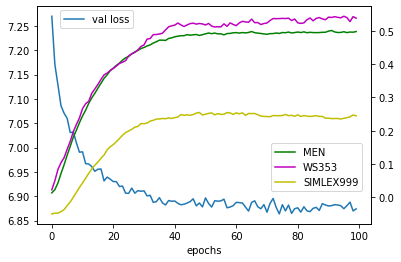

In [26]:
fig, ax1 = plt.subplots()

ax1.plot(val_losses, label='val loss')

ax2 = ax1.twinx()
ax2.plot(men, label='MEN', c='g')
ax2.plot(ws353, label='WS353', c='m')
ax2.plot(simlex999, label='SIMLEX999', c='y')

ax1.legend(loc=[0.07, 0.9])
ax2.legend(loc=[0.7, 0.15])

ax1.set_xlabel('epochs');

In [27]:
%%capture

val_losses, accuracies, task_perf = [], [], []
for i in range(40):
    learn.load(f'text_embeddings_2_{i}')
    loss, accuracy = learn.validate()
    val_losses.append(loss)
    accuracies.append(accuracy)
    
    embeddings = learn.model.embeddings.weight.cpu().detach().numpy()
    our_embeddings = Embedding(
        Vocabulary([w.lower() for w in vocab]),
        embeddings
    )

    task_perf.append([evaluate_similarity(our_embeddings, data.X, data.y) for name, data in iteritems(tasks)])

In [44]:
men, ws353, simlex999 = list(zip(*task_perf))

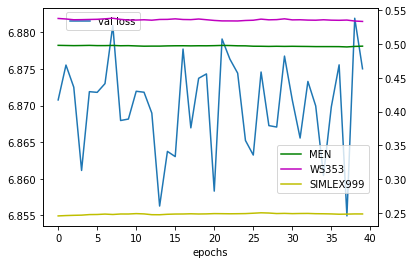

In [45]:
fig, ax1 = plt.subplots()

ax1.plot(val_losses, label='val loss')

ax2 = ax1.twinx()
ax2.plot(men, label='MEN', c='g')
ax2.plot(ws353, label='WS353', c='m')
ax2.plot(simlex999, label='SIMLEX999', c='y')

ax1.legend(loc=[0.07, 0.9])
ax2.legend(loc=[0.7, 0.15])

ax1.set_xlabel('epochs');